# Tokopedia Product Sentiment

In [102]:
from tqdm.notebook import tqdm

tqdm.pandas()

## Data Loading

In [103]:
import pandas as pd

df = pd.read_json(path_or_buf='data/reviews_new.jsonl', lines=True)
df.head()

,product_id,product_url,shop_id,shop_name,shop_url,review_id,star,review,source,variant_name,is_anonymous
0,NaN,https://www.tokopedia.com/multi-game-indonesia...,NaN,None,https://www.tokopedia.com/multi-game-indonesia,NaN,5,"Abis dibayar lgsg proses, da bes",html,None,NaN
1,NaN,https://www.tokopedia.com/multi-game-indonesia...,NaN,None,https://www.tokopedia.com/multi-game-indonesia,NaN,5,MANTAB GAN!!,html,None,NaN
2,NaN,https://www.tokopedia.com/multi-game-indonesia...,NaN,None,https://www.tokopedia.com/multi-game-indonesia,NaN,5,"Gamenya bagus, pas dapat diskon gede pula, top...",html,None,NaN
3,NaN,https://www.tokopedia.com/multi-game-indonesia...,NaN,None,https://www.tokopedia.com/multi-game-indonesia,NaN,5,Barang sesuai dan cepat sampai..,html,None,NaN
4,NaN,https://www.tokopedia.com/multi-game-indonesia...,NaN,None,https://www.tokopedia.com/multi-game-indonesia,NaN,5,gaming terbaik. Game nya seru!. kelengkapan se...,html,None,NaN


In [104]:
df.shape

(10423, 11)

In [106]:
df.star.value_counts()

star
5    9475
4     515
3     185
1     169
2      79
Name: count, dtype: int64

## Assessing Data

In [107]:
df[['review', 'star']].isna().sum()

review    286
star        0
dtype: int64

In [108]:
df.dropna(subset='review', inplace=True)
df[['review', 'star']].head()

,review,star
0,"Abis dibayar lgsg proses, da bes",5
1,MANTAB GAN!!,5
2,"Gamenya bagus, pas dapat diskon gede pula, top...",5
3,Barang sesuai dan cepat sampai..,5
4,gaming terbaik. Game nya seru!. kelengkapan se...,5


In [109]:
df[df.duplicated(subset='review', keep=False)]['review']

11                            barang original dan baguuuus
12                            barang original dan baguuuus
27                          Paket sudah diterima.\nThanks.
28                          Paket sudah diterima.\nThanks.
36                                                        
                               ...                        
10397                                                   ok
10400    sesuai deskripsi uk 30cm..barang bagus..materi...
10401    sesuai deskripsi uk 30cm..barang bagus..materi...
10412    monitor berfungsi dengan baik, cuma sedikit ke...
10413    monitor berfungsi dengan baik, cuma sedikit ke...
Name: review, Length: 2063, dtype: object

In [110]:
df.drop_duplicates(subset='review', inplace=True)

In [111]:
df.duplicated().sum()

0

In [112]:
df.shape

(8820, 11)

## Text Preprocessing

Kita hanya tertarik pada kolom `review` dan `star`. Maka buang kolom lain.

In [113]:
clean_df = df[['review', 'star']].copy()

### Case Folding

In [114]:
clean_df.review = clean_df.review.map(lambda x: x.lower())
clean_df.head()

,review,star
0,"abis dibayar lgsg proses, da bes",5
1,mantab gan!!,5
2,"gamenya bagus, pas dapat diskon gede pula, top...",5
3,barang sesuai dan cepat sampai..,5
4,gaming terbaik. game nya seru!. kelengkapan se...,5


### Remove Special Characters

#### Numbers

In [115]:
clean_df[clean_df.review.str.contains(r'\d')]

,review,star
31,description kurang lengkap..ternyata cma jual ...,1
32,"kurirnya ga jujur, bilang harga 4000 padahal d...",1
33,"kirain 100pcs trnyata 1 bola aza,,,, \ntp y sd...",2
42,"packing bagus, tapi soal selera x ya , pertama...",4
43,"mudah2an nda rusak, pengiriman via paxel sanga...",5
...,...,...
10367,ok bgt udah pake dari 2019 ga pernah ganti sel...,5
10382,"sebenernya secara kualitas barang cukup baik,s...",3
10383,"jahitan rapih, puas lah berkali&#34; order kesini",5
10400,sesuai deskripsi uk 30cm..barang bagus..materi...,5


In [116]:
import re


def preprocess_numbers(x):
    # Pattern 1: Price expressions - convert to [PRICE] token
    price_pattern = r"\b\d+(?:[,.]\d+)*(?:rb|ribu|k|jt|juta|m|million)\b"
    x = re.sub(price_pattern, "[PRICE]", x)

    # Pattern 2: Simple math expressions - remove these
    math_pattern = r"\b\d+[\+\-\*\/]\d+\b"
    x = re.sub(math_pattern, "", x)

    # Pattern 3: Split number prefix from words (e.g., 2hari -> 2 hari)
    word_prefix_pattern = r"(\d+)(\w+)"
    x = re.sub(word_prefix_pattern, r"\1 \2", x)

    # Pattern 4: Remove repeated words (e.g., masing2 -> masing-masing)
    repeated_word_pattern = r"(\w+)2\b"
    x = re.sub(repeated_word_pattern, r"\1-\1", x)

    # Pattern 5: Remove standalone numbers that aren't part of important expressions (time and/or quantity)
    # This should run last to avoid interfering with other patterns
    standalone_num_pattern = r"\b\d+\b(?!\s+(?:tahun|thn|bulan|bln|hari|hr|minggu|mgg|jam|jm|menit|mnt|detik|dtk|pcs|kantong|kantng|bungkus|box|paket|biji|buah))"
    x = re.sub(standalone_num_pattern, "", x)

    return x.strip()


clean_df.review = clean_df.review.map(preprocess_numbers)


In [117]:
clean_df[clean_df.review.str.contains(r'\d')]

,review,star
33,"kirain 100 pcs trnyata bola aza,,,, \ntp y sd...",2
52,2 hr sampai.. blm di coba krn puasa. mudah-mud...,5
107,"packing rapi, overall minyak rambut nya kurang...",4
123,barang okay sangat gampang digunakan dan sanga...,5
156,"cukup wangi, medium strong, medium shine. belu...",5
...,...,...
10032,"ok bgtt, sudah dipakai untuk perjalanan 4 jam...",5
10255,kalau ada yg minat bisa pesan di toko harjunsh...,5
10302,"pembelian ke dua. dapetny 2 pcs, kalo pake ti...",5
10356,"favoriiit paraaah, bagus banget ini makasih y...",5


#### Punctuation

In [118]:
import string


def remove_punctuation(x):
    punctuations = set(string.punctuation)
    cleaned_text = ''.join(char for char in x if char not in punctuations)
    return cleaned_text

clean_df.review.map(remove_punctuation)

0                          abis dibayar lgsg proses da bes
1                                               mantab gan
2             gamenya bagus pas dapat diskon gede pula top
3                           barang sesuai dan cepat sampai
4        gaming terbaik game nya seru kelengkapan sesua...
                               ...                        
10418          pelayanan sangat ramah  cepat terimakasih 🙏
10419    oke monitorny mantap bener cuy paling worth it...
10420    semoga aman maaf baru review baru sempet tes m...
10421    pesan dangan packing kayu  instant yang datang...
10422    toko nya ramah bgt👍 fast respon jga🤟 keren deh...
Name: review, Length: 8820, dtype: object

In [119]:
clean_df.review = clean_df.review.map(remove_punctuation)

#### Emoji

Emoji is not directly removed as it might helpful for the sentiment. For example love emoji (❤️‍) shows a positive sentiment. Instead the emoji is turned to its description or name. So that embedding model can handle it like text.

In [120]:
import re
import emoji

def preprocess_emojis(x):
    text = emoji.demojize(x, language='id', delimiters=(" ", " "))
    return text.replace('_', ' ').strip()


clean_df.review.map(preprocess_emojis)

0                          abis dibayar lgsg proses da bes
1                                               mantab gan
2             gamenya bagus pas dapat diskon gede pula top
3                           barang sesuai dan cepat sampai
4        gaming terbaik game nya seru kelengkapan sesua...
                               ...                        
10418    pelayanan sangat ramah  cepat terimakasih  mel...
10419    oke monitorny mantap bener cuy paling worth it...
10420    semoga aman maaf baru review baru sempet tes m...
10421    pesan dangan packing kayu  instant yang datang...
10422    toko nya ramah bgt jempol ke atas  fast respon...
Name: review, Length: 8820, dtype: object

In [121]:
clean_df.review = clean_df.review.map(preprocess_emojis)

#### Repeated Letters

In [122]:
def normalize_repeated_letters(word):
    # Only replace if a character repeats 3 or more times
    return re.sub(r'(.)\1{2,}', r'\1', word)

def normalize_review(text):
    return ' '.join([normalize_repeated_letters(w) for w in text.split()])

clean_df.review = clean_df.review.map(normalize_review)

In [123]:
clean_df.review

0                          abis dibayar lgsg proses da bes
1                                               mantab gan
2             gamenya bagus pas dapat diskon gede pula top
3                           barang sesuai dan cepat sampai
4        gaming terbaik game nya seru kelengkapan sesua...
                               ...                        
10418    pelayanan sangat ramah cepat terimakasih melip...
10419    oke monitorny mantap bener cuy paling worth it...
10420    semoga aman maaf baru review baru sempet tes m...
10421    pesan dangan packing kayu instant yang datang ...
10422    toko nya ramah bgt jempol ke atas fast respon ...
Name: review, Length: 8820, dtype: object

#### Common Mistakes

In [225]:
# common abbreviated words and common slangs

common_abbv = {
    'yg': 'yang',
    'gak': 'tidak',
    'nggak': 'tidak',
    'gk': 'tidak',
    'ga': 'tidak',
    'tdk': 'tidak',
    'gitu': 'begitu',
    'bgt': 'banget',
    'bgtu': 'begitu',
    'lgsg': 'langsung',
    'mantab': 'mantap',
    'mntp': 'mantap',
    'moga': 'semoga',
    'gede': 'besar',
    'thx': 'terima kasih',
    'makasih': 'terima kasih',
    'terimakasih': 'terima kasih',
    'trims': 'terima kasih',
    'tp': 'tapi',
    'sy': 'saya',
    'sya': 'saya',
    'sdh': 'sudah',
    'smpai': 'sampai',
    'dgn': 'dengan',
}

def replace_abbreviations(text):
    for abbv, full in common_abbv.items():
        text = re.sub(r'\b' + abbv + r'\b', full, text)
    return text

clean_df.review = clean_df.review.map(replace_abbreviations)

In [173]:
# remove 'nya' word which detached from the word before it
def remove_detached_nya(text):
    return re.sub(r'(\w+)\s+nya\b', r'\1', text)

clean_df.review = clean_df.review.map(remove_detached_nya)

In [174]:
clean_df.review

0                       abis bayar langsung proses da bes
1                                              mantap gan
2                      gamenya bagus pas diskon besar top
3                                     barang sesuai cepat
4        gaming baik game seru lengkap sesuai produk baru
                              ...                        
8799    layan sangat ramah cepat terima kasih lipat ta...
8800    oke monitorny mantap bener cuy paling worth it...
8801    semoga aman maaf baru review baru sempet tes m...
8802    pesan dang packing kayu instant datang packing...
8803    toko ramah banget jempol atas fast respon jga ...
Name: review, Length: 8804, dtype: object

#### Stopword Removal

In [124]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [125]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import word_tokenize

factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

In [206]:
def remove_stopwords(x):
    word_token = word_tokenize(x)
    important_words = [word for word in word_token if word.lower() not in stopwords]
    return ' '.join(important_words)

clean_df.review.map(remove_stopwords)

0                       abis bayar langsung proses da bes
1                                              mantap gan
2                      gamenya bagus pas diskon besar top
3                                     barang sesuai cepat
4        gaming baik game seru lengkap sesuai produk baru
                              ...                        
8799    layan sangat ramah cepat terima kasih lipat ta...
8800    oke monitorny mantap bener cuy paling worth it...
8801    semoga aman maaf baru review baru sempet tes m...
8802    pesan dang packing kayu instant datang packing...
8803    toko ramah banget jempol atas fast respon jga ...
Name: review, Length: 8804, dtype: object

In [226]:
clean_df.review = clean_df.review.map(remove_stopwords)

#### Whitespaces

In [208]:
def remove_whitespaces(x):
    return re.sub(r"\s+", " ", x).strip()

clean_df.review.map(remove_whitespaces)

0                       abis bayar langsung proses da bes
1                                              mantap gan
2                      gamenya bagus pas diskon besar top
3                                     barang sesuai cepat
4        gaming baik game seru lengkap sesuai produk baru
                              ...                        
8799    layan sangat ramah cepat terima kasih lipat ta...
8800    oke monitorny mantap bener cuy paling worth it...
8801    semoga aman maaf baru review baru sempet tes m...
8802    pesan dang packing kayu instant datang packing...
8803    toko ramah banget jempol atas fast respon jga ...
Name: review, Length: 8804, dtype: object

In [227]:
clean_df.review = clean_df.review.map(remove_whitespaces)

In [228]:
# drop any empty row (no text) after all the preprocessing
clean_df = clean_df[~clean_df["review"].str.match(r"^\s*$", na=False)]

### Stemming

In [132]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [133]:
clean_df.review = clean_df.review.progress_map(lambda x: stemmer.stem(x))

  0%|          | 0/8804 [00:00<?, ?it/s]

In [134]:
clean_df.review

0                            abis bayar lgsg proses da bes
1                                               mantab gan
2                        gamenya bagus pas diskon gede top
3                                      barang sesuai cepat
4        gaming baik game nya seru lengkap sesuai produ...
                               ...                        
10418    layan sangat ramah cepat terimakasih lipat tangan
10419    oke monitorny mantap bener cuy paling worth it...
10420    moga aman maaf baru review baru sempet tes mon...
10421    pesan dang packing kayu instant datang packing...
10422    toko nya ramah bgt jempol atas fast respon jga...
Name: review, Length: 8804, dtype: object

In [ ]:
clean_df.to_csv('data/clean_reviews.csv', index=False)

## Embedding Model

For this case we opt for using Fasttext.

>FastText breaks down words into smaller parts, such as n-grams, and computes vector representations for each of these subword parts. Then, the vector representation for the word is obtained by combining the subword vectors that form the word. This approach helps FastText address the morphological variation of words in the text

*[dicoding](https://www.dicoding.com/academies/185/tutorials/37403)*

Suitable for multi typo, messed text found in product review.

In [176]:
import requests
import gzip
import os

def download_and_extract_gz(url, output_dir="web"):
    # Create the web directory in the current working directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get the filename from the URL
    filename = os.path.basename(url)
    output_filename = os.path.splitext(filename)[0]  # Remove .gz extension

    # Save the downloaded .gz file
    gz_path = os.path.join(output_dir, filename)
    output_path = os.path.join(output_dir, output_filename)

    # Check if the extracted file already exists
    if os.path.exists(output_path):
        print(f"File already exists at {output_path}. Skipping download and extraction.")
        return output_path

    # Download the file
    print(f"Downloading from {url}...")
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for failed downloads

    with open(gz_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    # Extract the .gz file
    print(f"Extracting to {output_path}...")
    with gzip.open(gz_path, 'rb') as gz_file:
        with open(output_path, 'wb') as output_file:
            output_file.write(gz_file.read())

    print(f"Download and extraction complete! File saved to {output_path}")
    return output_path


extracted_path = download_and_extract_gz('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz', 'model')
print(f"Extracted file is at: {extracted_path}")

File already exists at model/cc.id.300.vec. Skipping download and extraction.
Extracted file is at: model/cc.id.300.vec


In [136]:
from gensim.models import KeyedVectors

# only run this one time
# word_vectors = KeyedVectors.load_word2vec_format('model/cc.id.300.vec')
# word_vectors.save('model/cc.id.300.kvmodel')

In [137]:
word_vectors = KeyedVectors.load('model/cc.id.300.kvmodel') # loading the saved format

### Load Data

In [177]:
# load the cleaned data if necessary
import pandas as pd

clean_df = pd.read_csv('data/clean_reviews.csv')
clean_df.head()

,review,star,label
0,abis bayar langsung proses da bes,5,positive
1,mantap gan,5,positive
2,gamenya bagus pas diskon besar top,5,positive
3,barang sesuai cepat,5,positive
4,gaming baik game seru lengkap sesuai produk baru,5,positive


In [218]:
len(clean_df)

8804

In [219]:
clean_df.star.value_counts()

star
5    8000
4     463
3     156
1     121
2      64
Name: count, dtype: int64

In [232]:
from collections import Counter

top_words_per_star = {}

for star in sorted(clean_df.star.unique()):
    reviews = clean_df[clean_df.star == star].review
    words = ' '.join(reviews).split()
    most_common = Counter(words).most_common(10)
    top_words_per_star[star] = most_common

top_words_per_star

{1: [('kirim', 38),
  ('barang', 37),
  ('beli', 30),
  ('jual', 18),
  ('wajah', 16),
  ('pesan', 15),
  ('sesuai', 13),
  ('lama', 13),
  ('sama', 13),
  ('terima', 10)],
 2: [('kurang', 12),
  ('packing', 12),
  ('kirim', 11),
  ('bagus', 10),
  ('barang', 10),
  ('ukur', 9),
  ('kali', 8),
  ('baik', 8),
  ('kualitas', 8),
  ('hari', 8)],
 3: [('barang', 29),
  ('sesuai', 26),
  ('kirim', 25),
  ('kurang', 21),
  ('lama', 18),
  ('beli', 17),
  ('baru', 17),
  ('baik', 15),
  ('packing', 14),
  ('terima', 14)],
 4: [('barang', 132),
  ('kirim', 123),
  ('bagus', 86),
  ('sesuai', 84),
  ('kurang', 61),
  ('lama', 58),
  ('cepat', 57),
  ('baik', 55),
  ('banget', 45),
  ('terima', 44)],
 5: [('barang', 2178),
  ('bagus', 1914),
  ('sesuai', 1833),
  ('cepat', 1778),
  ('kirim', 1682),
  ('terima', 1372),
  ('atas', 1221),
  ('jempol', 1191),
  ('kasih', 1130),
  ('aman', 1129)]}

In [221]:
# sample word vector for indonesian slang
vector = word_vectors['pas']
vector

array([ 8.500e-03,  2.340e-02,  7.650e-02,  1.607e-01, -4.070e-02,
       -3.220e-02, -1.660e-02,  3.230e-02, -4.750e-02, -1.565e-01,
        8.840e-02, -7.720e-02, -1.795e-01,  7.000e-02,  2.100e-02,
        4.680e-02,  8.220e-02, -5.200e-02, -2.670e-02,  9.500e-03,
       -7.170e-02,  2.720e-02,  1.087e-01,  1.154e-01,  1.200e-01,
       -3.530e-02,  8.670e-02, -4.000e-03,  1.357e-01,  5.650e-02,
       -1.220e-02, -9.820e-02,  1.156e-01, -5.960e-02,  4.910e-02,
       -2.950e-02, -2.810e-02,  1.446e-01,  8.920e-02, -1.187e-01,
        3.440e-02, -1.341e-01,  2.920e-02,  1.693e-01, -8.770e-02,
        4.380e-02,  5.060e-02,  9.490e-02, -7.800e-03, -4.990e-02,
        8.640e-02, -1.810e-02, -1.202e-01,  3.410e-02, -6.320e-02,
       -6.490e-02,  2.187e-01,  1.015e-01, -3.100e-03, -9.290e-02,
        5.130e-02, -1.510e-01, -5.860e-02, -7.520e-02, -8.900e-03,
       -5.600e-03, -1.007e-01,  3.500e-03,  7.860e-02,  3.480e-02,
       -5.120e-02,  1.630e-02, -3.050e-02, -6.550e-02,  8.530e

### Prepping Data for Training

In [233]:
clean_df[clean_df['star'] == 5].review.sample(5).values

array(['bertahuntahun perang ribat trauma trauma pribadi perfeksionis sedikit ocd butuh banyak ajar utk adaptasi ekspektasi semoga buku',
       'sesuai pesan alhamdulillah cocok atas biang keringat anak',
       'terima kasih mantap banget masa aktif langsung masuk cepet banget',
       'beli sim card buat rombong minggu depan baru aktif semoga hasil',
       'bahan kertas bagus cetak bagus plg penting adminnya gercep banget aku baru order jam malam cm chat n minta pagipagi kirim krn mau pakai hari besok'],
      dtype=object)

In [222]:
clean_df[clean_df['star'] == 4].review.sample(5).values

array(['kapasitas besar desain bagus ukur pas pesan datang sesuai harap kipasnyabagus kenceng tidakada cacat sama sekali emas bagus',
       'bagus kelas jual sendok mahal gin dukung gambar lebih oke lah deskripsi sizenya gt kyk tokotoko biar bingung pas milih',
       'sy kasih bintang datang warna putih bukan abu abu',
       'kirim tdk tepat waktu sesuai jadwal tgl tiba',
       'alhamdulillah pesan sdh dgn aman dn baik kwalitas barang tajam baru coba smoga mesin benarbenar original bagus aamiin'],
      dtype=object)

In [ ]:
clean_df[clean_df['star'] == 3].review.sample(5).values

array(['kendor copotcopot jarak rekat terlalu kecil jd dikencengin',
       'penyok irit bubble wrap pelit menang design sja bahan tipis mudah penyok barang mahal harga segitu ikut video foto klo oamera kurang banget lihat asli liat langsung parah',
       'memang beli online resiko cuman ngasih foto',
       'packing kecewa kertas tipis plastik buku cacad',
       'bahan tipis terawang'], dtype=object)

In [ ]:
clean_df[clean_df['star'] == 2].review.sample(5).values

array(['kurang suka kwalitasnya tipis',
       'kesel banget udh beberapa hari dtg selalu keruh bening arti air kelapa lama tahan cmn 1 hari kulkas bsknya jd banyak buang krn bis',
       'kali enak seblmnya bumbubumbu kurang', 'kurang segar',
       'pikir isi banyak nyata cuma 1 pcs'], dtype=object)

In [ ]:
clean_df[clean_df['star'] == 1].review.sample(5).values

array(['kirim packing toko baik cuman mattressnya gembos sama skali worth price mattress sama bantal lama gepeng tebal mirip kualitas harg',
       'kirim barang lapak si seller minta tukar minta video unboxingnya',
       'semuha size sma wajah mata atas cek size tera ukur produk benar jauh error order baju ukur sama semua mubazir',
       'ukur kecilgk cmreal dtg hny cm',
       'baru kali sen pempek asam sesuai rasa biasa cuko baik sayang banget baru buka aju komplain'],
      dtype=object)

The decision to label the data is based on the fact that the data is highly imbalanced, 5-star alone has around 90% of the total data. Also looking by the most frequent word and some samples of each star we consider that the 3 and below starred reviews is considered negative, 4 is neutral as it has some mixed sentiment or just neither happy nor hate about the product, and finally 5 for positive.

In [270]:
def star_to_label(x):
    if x <= 3:
        return 'negative'
    elif x == 5:
        return 'positive'
    else:
        return 'neutral'

clean_df['label'] = clean_df.star.map(star_to_label)
y = clean_df.label.values  # Target variable

In [271]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
y = le.fit_transform(y)

# split into train val test
X_train, X_temp, y_train, y_temp = train_test_split(clean_df.review.values, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((7043,), (880,), (881,))

In [274]:
le.inverse_transform([0, 1, 2])

array(['negative', 'neutral', 'positive'], dtype=object)

### Extract Feature

We are going to experiment with Fasttext and TF-IDF, since TF-IDF considers the importance of the word accross documents. Hopefull when combined give the word more meaning.

#### Fasttext Only

In [241]:
import numpy as np


def get_document_vector(text, vector_size=300):
    sentence_words = text.split()
    vectors = [word_vectors[word] for word in sentence_words if word in word_vectors]

    if not vectors:
        return np.zeros(vector_size)  # Return zeros if no words are found

    # Return the average vector
    return np.mean(vectors, axis=0)

In [242]:
# Create feature vectors
X_train_ft = np.array([get_document_vector(review) for review in X_train])
X_val_ft = np.array([get_document_vector(review) for review in X_val])
X_test_ft = np.array([get_document_vector(review) for review in X_test])
X_train_ft.shape, X_val_ft.shape, X_test_ft.shape

((7043, 300), (880, 300), (881, 300))

#### Fasttext-TFIDF

In [243]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
# Fit the vectorizer on the training data
# notice that we dont fit on the whole data as this will cause data leakage
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
feature_names = tfidf_vectorizer.get_feature_names_out()
word_to_tfidf = dict(zip(feature_names, tfidf_vectorizer.idf_))

In [244]:
pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names).head(10)

,10,100,23,30,50,a1,a4,a7,aamii,aamiin,...,zama,zampai,zebra,zegarr,zionis,ziplock,ziqrah,zonk,zoo,zve1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [245]:
def get_document_vector_tfidf(text, vector_size=300):
    sentence_words = text.split()

    # Get vectors and weights for each word
    word_vectors_list = []
    word_weights = []

    for word in sentence_words:
        if word in word_vectors and word in word_to_tfidf:
            word_vectors_list.append(word_vectors[word])
            word_weights.append(word_to_tfidf[word])

    if not word_vectors_list:
        return np.zeros(vector_size)

    word_vectors_array = np.array(word_vectors_list)
    word_weights = np.array(word_weights)

    # normalize weights
    word_weights = word_weights / np.sum(word_weights)

    # calculate weighted average (i.e. the fasttext vector times the tfidf weight for each word)
    weighted_average = np.zeros(vector_size)
    for i, vector in enumerate(word_vectors_array):
        weighted_average += vector * word_weights[i]

    return weighted_average

In [246]:
X_train_tfidf_ft = np.array([get_document_vector_tfidf(review) for review in X_train])
X_val_tfidf_ft = np.array([get_document_vector_tfidf(review) for review in X_val])
X_test_tfidf_ft = np.array([get_document_vector_tfidf(review) for review in X_test])
X_train_tfidf_ft.shape, X_val_tfidf_ft.shape, X_test_tfidf_ft.shape

((7043, 300), (880, 300), (881, 300))

## Training Model

### XGBoost

In [247]:
from xgboost import XGBClassifier, callback

def create_xgboost(**kwargs):
    return XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        objective='multi:softmax',
        num_class=len(le.classes_),
        random_state=42,
        early_stopping_rounds=10,
        eval_metric='mlogloss',
        **kwargs
    )

xgb_ft = create_xgboost()
xgb_tfidf_ft = create_xgboost()

In [248]:
xgb_ft.fit(X_train_ft, y_train,
           eval_set=[(X_val_ft, y_val)],
           verbose=True)

[0]	validation_0-mlogloss:0.98982
[1]	validation_0-mlogloss:0.89994
[2]	validation_0-mlogloss:0.82413
[3]	validation_0-mlogloss:0.75929
[4]	validation_0-mlogloss:0.70375
[5]	validation_0-mlogloss:0.65644
[6]	validation_0-mlogloss:0.61446
[7]	validation_0-mlogloss:0.57795
[8]	validation_0-mlogloss:0.54673
[9]	validation_0-mlogloss:0.51943
[10]	validation_0-mlogloss:0.49525
[11]	validation_0-mlogloss:0.47433
[12]	validation_0-mlogloss:0.45443
[13]	validation_0-mlogloss:0.43762
[14]	validation_0-mlogloss:0.42279
[15]	validation_0-mlogloss:0.41113
[16]	validation_0-mlogloss:0.39898
[17]	validation_0-mlogloss:0.38896
[18]	validation_0-mlogloss:0.38036
[19]	validation_0-mlogloss:0.37225
[20]	validation_0-mlogloss:0.36575
[21]	validation_0-mlogloss:0.36019
[22]	validation_0-mlogloss:0.35492
[23]	validation_0-mlogloss:0.34990
[24]	validation_0-mlogloss:0.34562
[25]	validation_0-mlogloss:0.34168
[26]	validation_0-mlogloss:0.33815
[27]	validation_0-mlogloss:0.33588
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)

In [249]:
xgb_tfidf_ft.fit(X_train_tfidf_ft, y_train,
                 eval_set=[(X_val_tfidf_ft, y_val)],
                 verbose=True)

[0]	validation_0-mlogloss:0.99140
[1]	validation_0-mlogloss:0.90206
[2]	validation_0-mlogloss:0.82727
[3]	validation_0-mlogloss:0.76312
[4]	validation_0-mlogloss:0.70825
[5]	validation_0-mlogloss:0.66137
[6]	validation_0-mlogloss:0.62065
[7]	validation_0-mlogloss:0.58482
[8]	validation_0-mlogloss:0.55348
[9]	validation_0-mlogloss:0.52570
[10]	validation_0-mlogloss:0.50206
[11]	validation_0-mlogloss:0.48165
[12]	validation_0-mlogloss:0.46378
[13]	validation_0-mlogloss:0.44665
[14]	validation_0-mlogloss:0.43234
[15]	validation_0-mlogloss:0.41867
[16]	validation_0-mlogloss:0.40787
[17]	validation_0-mlogloss:0.39892
[18]	validation_0-mlogloss:0.39033
[19]	validation_0-mlogloss:0.38273
[20]	validation_0-mlogloss:0.37579
[21]	validation_0-mlogloss:0.36984
[22]	validation_0-mlogloss:0.36424
[23]	validation_0-mlogloss:0.35967
[24]	validation_0-mlogloss:0.35609
[25]	validation_0-mlogloss:0.35289
[26]	validation_0-mlogloss:0.35015
[27]	validation_0-mlogloss:0.34692
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)

### Deep Learning

In [250]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


def create_dl(input_dim, output_dim=len(le.classes_), dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(512, activation='elu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='elu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='elu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


input_dim = 300
dl_ft = create_dl(input_dim)
dl_tfidf_ft = create_dl(input_dim)

/teamspace/studios/this_studio/product-sentiment/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [251]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist_ft = dl_ft.fit(X_train_ft, y_train, validation_data=(X_val_ft, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100


221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8978 - loss: 0.3982 - val_accuracy: 0.9080 - val_loss: 0.3033
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9040 - loss: 0.3195 - val_accuracy: 0.9057 - val_loss: 0.3299
Epoch 3/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9033 - loss: 0.3250 - val_accuracy: 0.8989 - val_loss: 0.3014
Epoch 4/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9047 - loss: 0.3092 - val_accuracy: 0.9057 - val_loss: 0.3126
Epoch 5/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9105 - loss: 0.2926 - val_accuracy: 0.9045 - val_loss: 0.3224
Epoch 6/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9065 - loss: 0.3058 - val_accuracy: 0.9034 - val_loss: 0.3037
Epoch 7/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9112 - loss: 0.2808 - val_accuracy: 0.9057 - val_loss: 0.3011
Epoch 8/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9071 - loss: 0.2871 - val_accuracy: 0.9068

In [252]:
hist_tfidf_ft = dl_tfidf_ft.fit(X_train_tfidf_ft, y_train, validation_data=(X_val_tfidf_ft, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100


221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8955 - loss: 0.4043 - val_accuracy: 0.9045 - val_loss: 0.3236
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9091 - loss: 0.3151 - val_accuracy: 0.9011 - val_loss: 0.3222
Epoch 3/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9063 - loss: 0.3030 - val_accuracy: 0.9000 - val_loss: 0.3098
Epoch 4/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9076 - loss: 0.3129 - val_accuracy: 0.8966 - val_loss: 0.3177
Epoch 5/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9026 - loss: 0.3047 - val_accuracy: 0.8977 - val_loss: 0.3199
Epoch 6/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9074 - loss: 0.2958 - val_accuracy: 0.9000 - val_loss: 0.3471
Epoch 7/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9118 - loss: 0.2816 - val_accuracy: 0.8989 - val_loss: 0.3141
Epoch 8/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9096 - loss: 0.2838 - val_accuracy: 0.9045

In [253]:
import matplotlib.pyplot as plt

def plot_training_history(history, figsize=(12, 5)):
    """
    Plot the training and validation metrics from a Keras/TensorFlow model's history.

    Parameters:
    -----------
    history : History object
        The history object returned by model.fit()
    figsize : tuple, optional
        Size of the figure (width, height)
    """
    # Get history dictionary
    hist = history.history

    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot training & validation loss
    axes[0].plot(hist['loss'], label='Training Loss')
    if 'val_loss' in hist:
        axes[0].plot(hist['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Plot training & validation accuracy if available
    if 'accuracy' in hist:
        axes[1].plot(hist['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in hist:
            axes[1].plot(hist['val_accuracy'], label='Validation Accuracy')
        axes[1].set_title('Model Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend(loc='lower right')
        axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # Print some metrics about the training
    epochs_trained = len(hist['loss'])
    print(f"Model trained for {epochs_trained} epochs")

    if 'val_loss' in hist:
        best_epoch = np.argmin(hist['val_loss'])
        best_val_loss = hist['val_loss'][best_epoch]
        print(f"Best validation loss: {best_val_loss:.4f} (epoch {best_epoch+1})")

        if 'val_accuracy' in hist:
            best_val_acc = hist['val_accuracy'][best_epoch]
            print(f"Validation accuracy at best epoch: {best_val_acc:.4f}")

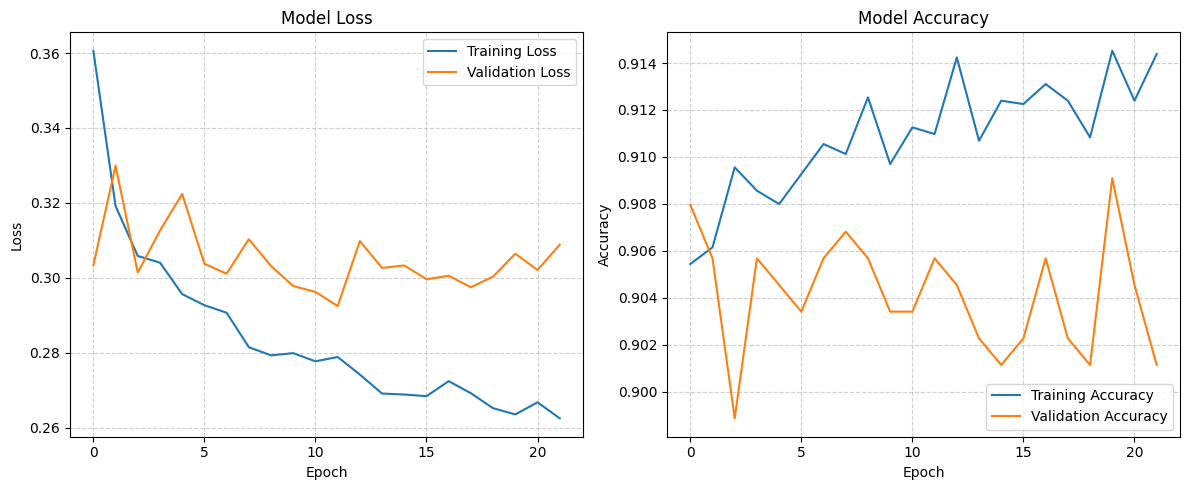

Model trained for 22 epochs
Best validation loss: 0.2925 (epoch 12)
Validation accuracy at best epoch: 0.9057


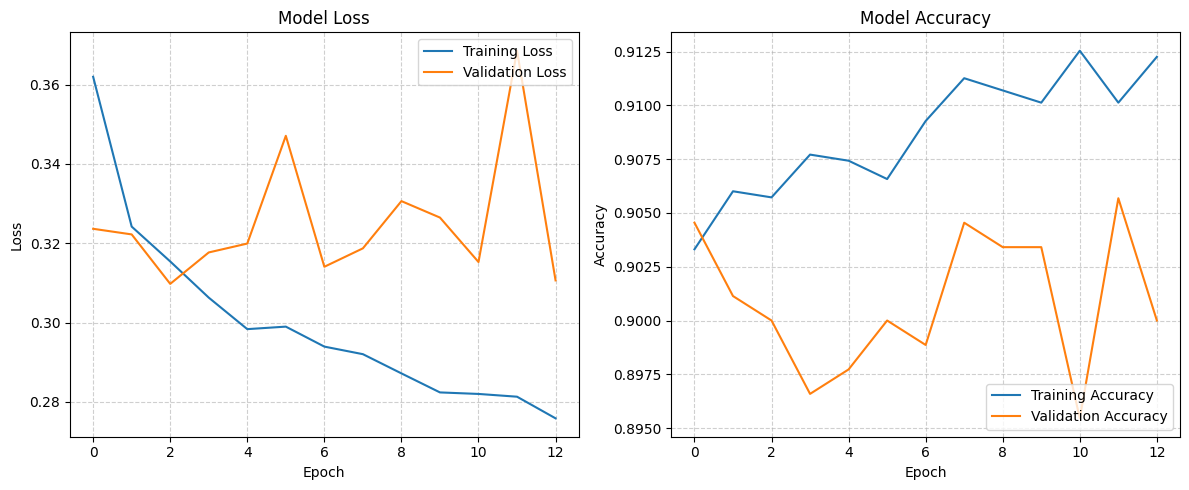

Model trained for 13 epochs
Best validation loss: 0.3098 (epoch 3)
Validation accuracy at best epoch: 0.9000


In [254]:
plot_training_history(hist_ft)
plot_training_history(hist_tfidf_ft)

In [255]:
import os
import pickle

# Create directory for saving models if it doesn't exist
os.makedirs('model/saved_models', exist_ok=True)

# Save XGBoost models
xgb_ft.save_model('model/saved_models/xgb_fasttext.json')
xgb_tfidf_ft.save_model('model/saved_models/xgb_tfidf_fasttext.json')

# Save Deep Learning models
dl_ft.save('model/saved_models/dl_fasttext.keras')
dl_tfidf_ft.save('model/saved_models/dl_tfidf_fasttext.keras')

# Save TF-IDF vectorizer
with open('model/saved_models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save label encoder
with open('model/saved_models/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("All models saved successfully!")

All models saved successfully!


## Evaluation

In [275]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

results = {}

def evaluate_model(name, model, X_test, y_test, is_keras=False):
    if is_keras:
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
    else:
        y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred
    }

    print(f"\n----- {name} Evaluation -----")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

### XGBoost-Fasttext


----- XGBoost FastText Evaluation -----
Accuracy: 0.9047
Precision: 0.8243
Recall: 0.9047
F1 Score: 0.8626


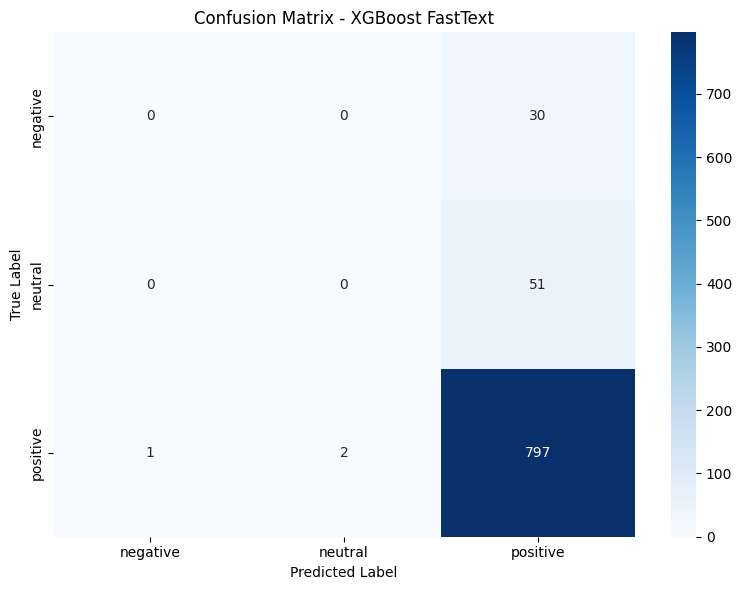

In [276]:
evaluate_model('XGBoost FastText', xgb_ft, X_test_ft, y_test)

### XGBoost-TFIDF-Fasttext

/teamspace/studios/this_studio/product-sentiment/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



----- XGBoost TF-IDF FastText Evaluation -----
Accuracy: 0.9058
Precision: 0.8244
Recall: 0.9058
F1 Score: 0.8632


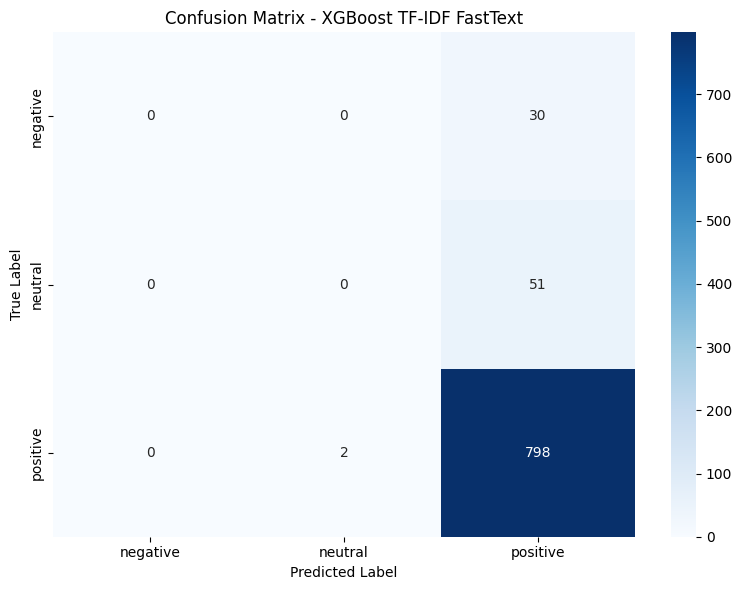

In [277]:
evaluate_model('XGBoost TF-IDF FastText', xgb_tfidf_ft, X_test_tfidf_ft, y_test)

### Deep Learning-Fasttext

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

----- Deep Learning FastText Evaluation -----
Accuracy: 0.9035
Precision: 0.8400
Recall: 0.9035
F1 Score: 0.8693


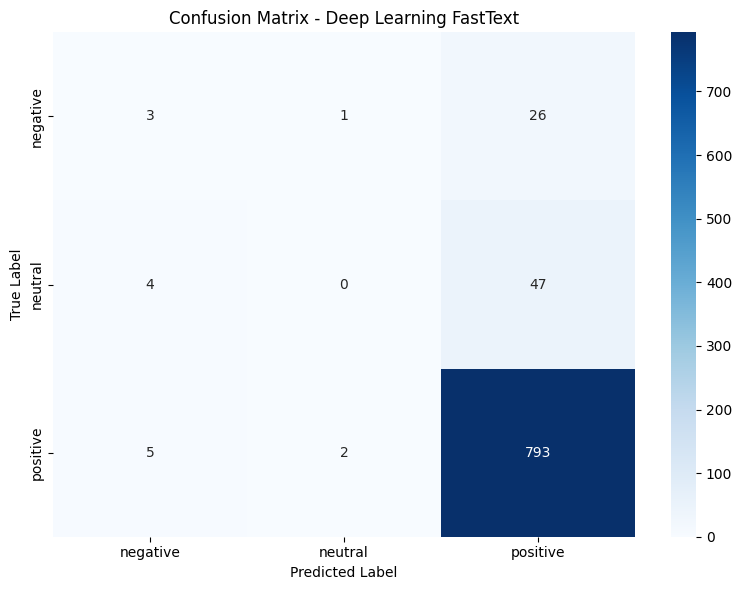

In [278]:
evaluate_model('Deep Learning FastText', dl_ft, X_test_ft, y_test, is_keras=True)

### Deep Learning-TFIDF-Fasttext

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 



----- Deep Learning TF-IDF FastText Evaluation -----
Accuracy: 0.9058
Precision: 0.8416
Recall: 0.9058
F1 Score: 0.8680


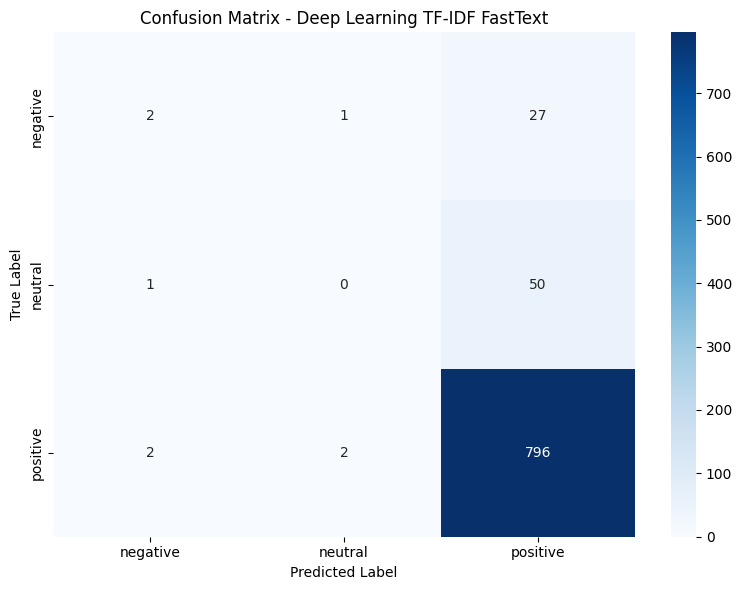

In [279]:
evaluate_model('Deep Learning TF-IDF FastText', dl_tfidf_ft, X_test_tfidf_ft, y_test, is_keras=True)

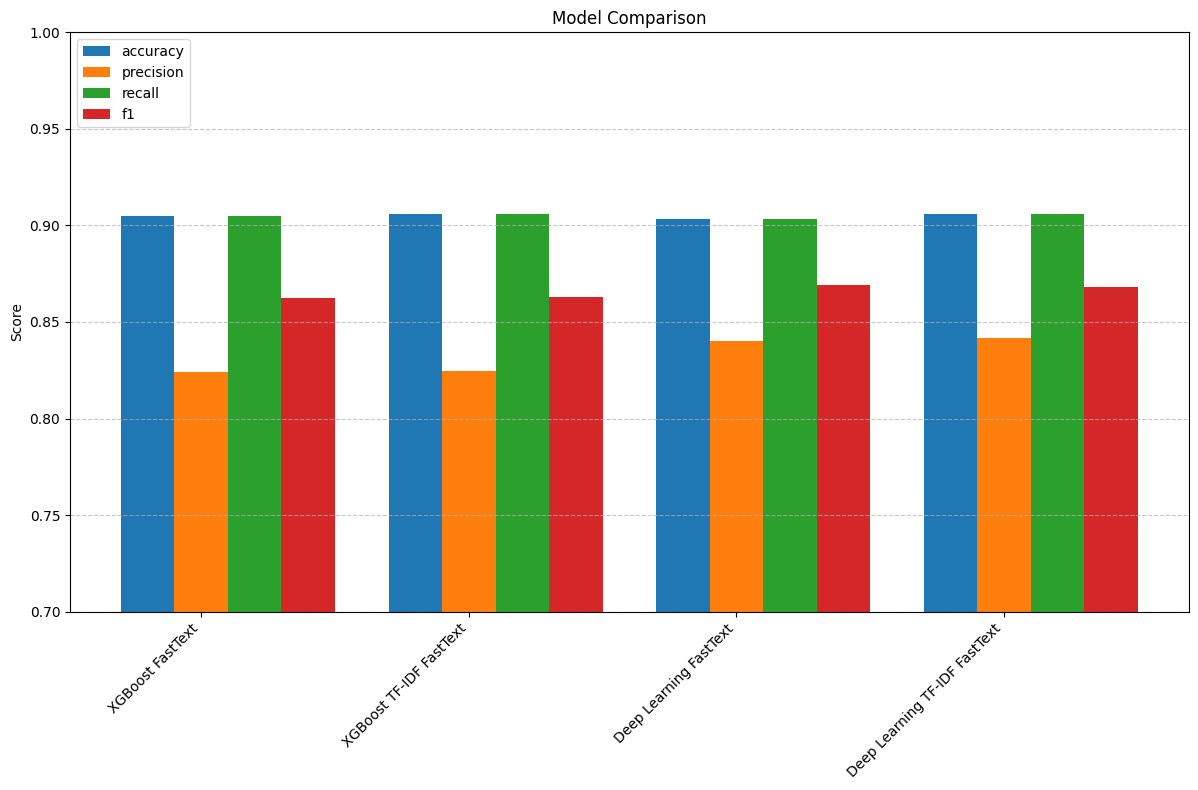

In [280]:
# Compare all models
model_names = list(results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1']

# Create comparison bar chart
plt.figure(figsize=(12, 8))
x = np.arange(len(model_names))
width = 0.2
multiplier = 0

for metric in metrics:
    offset = width * multiplier
    rects = plt.bar(x + offset, [results[model][metric] for model in model_names], width, label=metric)
    multiplier += 1

plt.ylabel('Score')
plt.title('Model Comparison')
plt.xticks(x + width, model_names, rotation=45, ha='right')
plt.legend(loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.7, 1.0)  # Set y-axis limits for better visibility
plt.show()

In [265]:
# Print summary table
print("\n----- Summary of Results -----")
for model in model_names:
    print(f"\n{model}:")
    for metric in metrics:
        print(f"  {metric.capitalize()}: {results[model][metric]:.4f}")


----- Summary of Results -----

XGBoost FastText:
  Accuracy: 0.9047
  Precision: 0.8243
  Recall: 0.9047
  F1: 0.8626

XGBoost TF-IDF FastText:
  Accuracy: 0.9058
  Precision: 0.8244
  Recall: 0.9058
  F1: 0.8632

Deep Learning FastText:
  Accuracy: 0.9035
  Precision: 0.8400
  Recall: 0.9035
  F1: 0.8693

Deep Learning TF-IDF FastText:
  Accuracy: 0.9058
  Precision: 0.8416
  Recall: 0.9058
  F1: 0.8680


## Inference Testing

The best-considered model is Deep Learning with Fasttext only, judging by F1-Score. Therefore this inference is using that model. Below is the sample review.

![](sample_image.png)

In [281]:
review = "bahan nya bagus, tapi size tidak sesuai, cocok untuk BB 50 ke 55. Akhirnya saya kasih ke anak saya..."

review_vector = get_document_vector_tfidf(review)
review_vector = review_vector.reshape(1, -1)
predicted_class = dl_ft.predict(review_vector)
predicted_class = np.argmax(predicted_class, axis=1)
predicted_label = le.inverse_transform(predicted_class)[0]
print(f"Predicted class for the review: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted class for the review: positive
